# *Detecting deforestation using Deep Learning*

Author@Japheth_Kimeu

Date: Jan, 2023

Data: Sentinel-2 image chips with corresponding masks 

Import packages

In [203]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import cv2

In [204]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [205]:
dir0 = 'sample_data/images'
dir1 = 'sample_data/masks'

Create dataframe for training, validation and testing datasets

In [206]:
# files=[]
# paths = []
# for dirname, _, filenames in os.walk(dir0):
#     for filename in filenames:
#         path = os.path.join(dirname, filename)    
#         paths.append(path)
#         files.append(filename)

files = []
image_path = []
for dirname, _, filenames in os.walk(dir0):
    for filename in filenames:
        path = os.path.join(dirname, filename)    
        image_path.append(path)
        
        file = filename.split(".")[0]
        files.append(file)

d = {"id": files, "image_path": image_path}
df = pd.DataFrame(data = d)
df = df.set_index('id')
df

image_path
id                                                       
deforestation_0    sample_data/images\deforestation_0.png
deforestation_1    sample_data/images\deforestation_1.png
deforestation_10  sample_data/images\deforestation_10.png
deforestation_2    sample_data/images\deforestation_2.png
deforestation_3    sample_data/images\deforestation_3.png
deforestation_4    sample_data/images\deforestation_4.png
deforestation_5    sample_data/images\deforestation_5.png
deforestation_6    sample_data/images\deforestation_6.png
deforestation_7    sample_data/images\deforestation_7.png
deforestation_8    sample_data/images\deforestation_8.png
deforestation_9    sample_data/images\deforestation_9.png

In [207]:
# mfiles=[]
# mpaths = []
# for dirname, _, filenames in os.walk(dir1):
#     for filename in filenames:
#         path = os.path.join(dirname, filename)    
#         mpaths.append(path)
#         mfiles.append(filename)

mfiles = []
mask_path = []
for dirname, _, filenames in os.walk(dir1):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        mask_path.append(path)
        
        mfile = filename.split(".")[0]
       # car_id = car_id.split("_mask")[0]
        mfiles.append(mfile)

        
d = {"id": mfiles,"mask_path": mask_path}
mask_df = pd.DataFrame(data = d)
mask_df = mask_df.set_index('id')
mask_df

mask_path
id                                                      
deforestation_0    sample_data/masks\deforestation_0.png
deforestation_1    sample_data/masks\deforestation_1.png
deforestation_10  sample_data/masks\deforestation_10.png
deforestation_2    sample_data/masks\deforestation_2.png
deforestation_3    sample_data/masks\deforestation_3.png
deforestation_4    sample_data/masks\deforestation_4.png
deforestation_5    sample_data/masks\deforestation_5.png
deforestation_6    sample_data/masks\deforestation_6.png
deforestation_7    sample_data/masks\deforestation_7.png
deforestation_8    sample_data/masks\deforestation_8.png
deforestation_9    sample_data/masks\deforestation_9.png

Lets look at our images and masks

(256, 256)


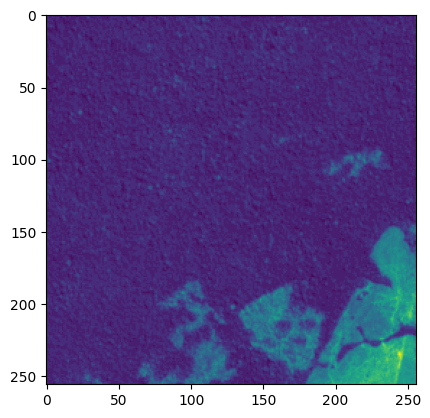

(256, 256)


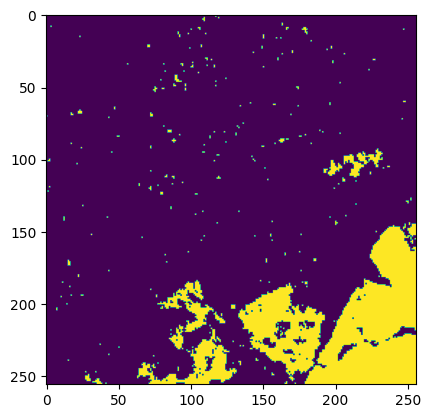

In [208]:
import cv2
path0='sample_data/images/deforestation_5.png'
img0=cv2.imread(path0,cv2.IMREAD_GRAYSCALE)
shape0=img0.shape
print(shape0)
plt.imshow(img0)
plt.show()

path1='sample_data/masks/deforestation_5.png'
img1=cv2.imread(path1,cv2.IMREAD_GRAYSCALE)
shape1=img1.shape
print(shape1)
plt.imshow(img1)
plt.show()

In [209]:
# df0=pd.DataFrame(columns=['file','path','mpath','class'])
# df0['file']=files
# df0['path']=paths
# df0['mpath']=mpaths
# df0['class']=1

# display(df0)
# df0.sample(frac=1)

df["mask_path"] = mask_df["mask_path"]
df

image_path  \
id                                                          
deforestation_0    sample_data/images\deforestation_0.png   
deforestation_1    sample_data/images\deforestation_1.png   
deforestation_10  sample_data/images\deforestation_10.png   
deforestation_2    sample_data/images\deforestation_2.png   
deforestation_3    sample_data/images\deforestation_3.png   
deforestation_4    sample_data/images\deforestation_4.png   
deforestation_5    sample_data/images\deforestation_5.png   
deforestation_6    sample_data/images\deforestation_6.png   
deforestation_7    sample_data/images\deforestation_7.png   
deforestation_8    sample_data/images\deforestation_8.png   
deforestation_9    sample_data/images\deforestation_9.png   

                                               mask_path  
id                                                        
deforestation_0    sample_data/masks\deforestation_0.png  
deforestation_1    sample_data/masks\deforestation_1.png  
deforestation_10  sample_data/masks\deforestation_10.png  
deforestation_2    sample_data/masks\deforestation_2.png  
deforestation_3    sample_data/masks\deforestation_3.png  
deforestation_4    sample_data/masks\deforestation_4.png  
deforestation_5    sample_data/masks\deforestation_5.png  
deforestation_6    sample_data/masks\deforestation_6.png  
deforestation_7    sample_data/masks\deforestation_7.png  
deforestation_8    sample_data/masks\deforestation_8.png  
deforestation_9    sample_data/masks\deforestation_9.png

In [210]:
n = len(df)
print(n)
test_df = df.iloc[(n//10)*3:(n//10)*4]
print(test_df)

11
                                             image_path  \
id                                                        
deforestation_2  sample_data/images\deforestation_2.png   

                                             mask_path  
id                                                      
deforestation_2  sample_data/masks\deforestation_2.png  


**Preprocess data**

We apply data augmentations and process our dataset

In [215]:
img_size = [256,256]


def data_augmentation(car_img, mask_img):
    if tf.random.uniform(()) > 0.5:
        car_img = tf.image.flip_left_right(car_img)
        mask_img = tf.image.flip_left_right(mask_img)

    return car_img, mask_img

def preprocessing(image_path, mask_path):
    car_img = tf.io.read_file(image_path) 
    car_img = tf.image.decode_png(car_img, channels=3)
    car_img = tf.image.resize(car_img, img_size)
    car_img = tf.cast(car_img, tf.float32) / 255.0
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_png(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)
    
    return car_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["image_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["image_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

In [216]:
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)
test = create_dataset(test_df)

In [217]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 16
BUFFER_SIZE = 1000

In [218]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)

In [219]:
def display(display_list):
    plt.figure(figsize=(12,12))
    title = ['Input Image','True Mask','Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

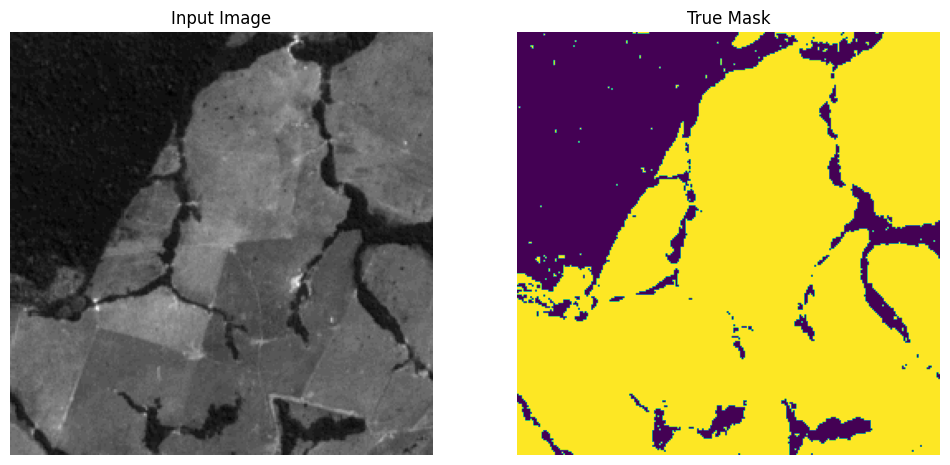

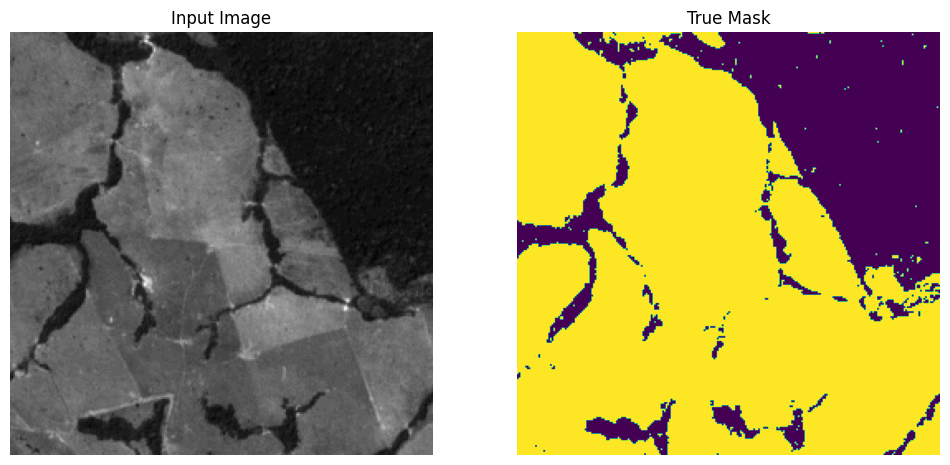

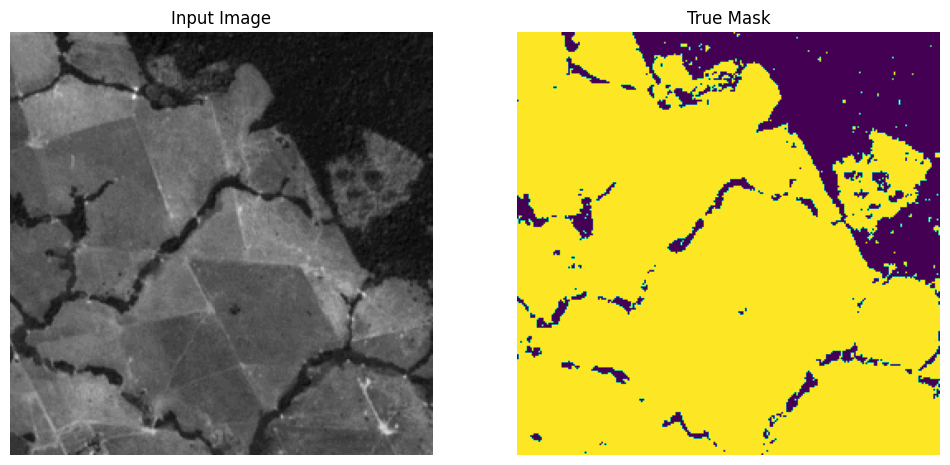

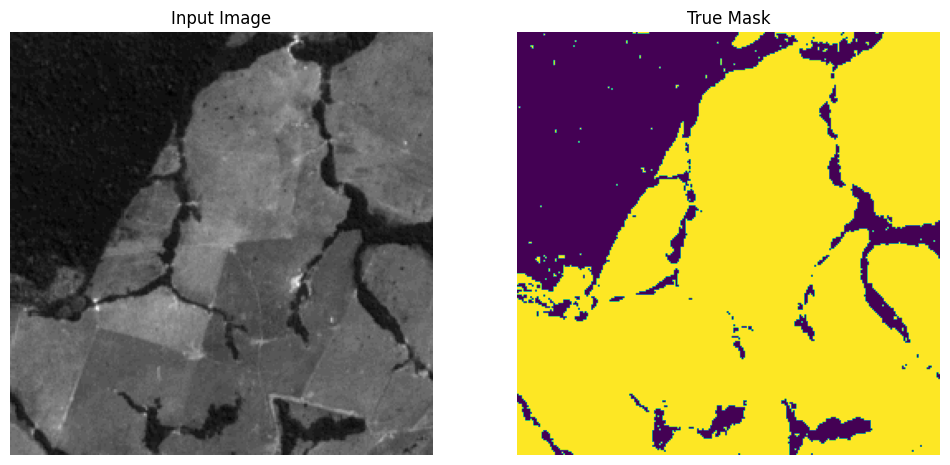

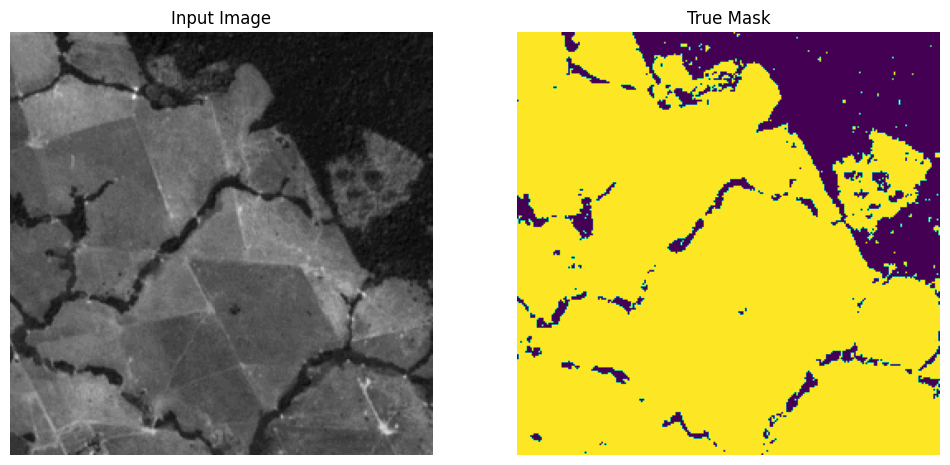

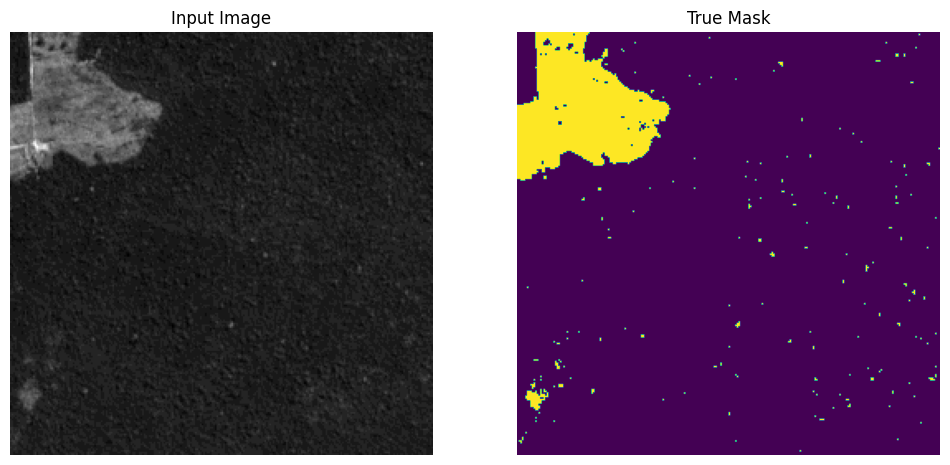

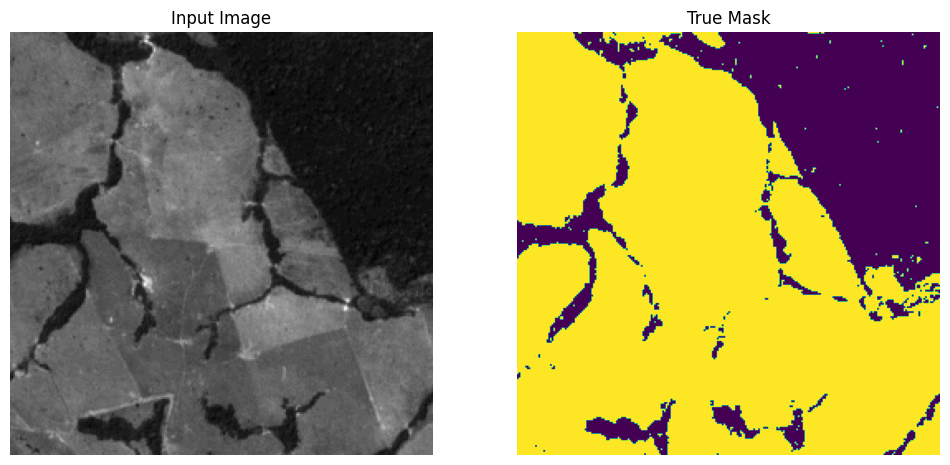

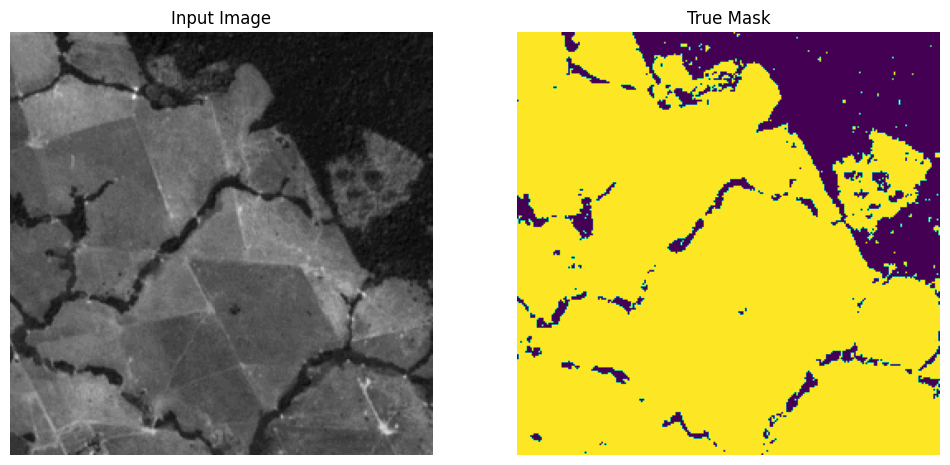

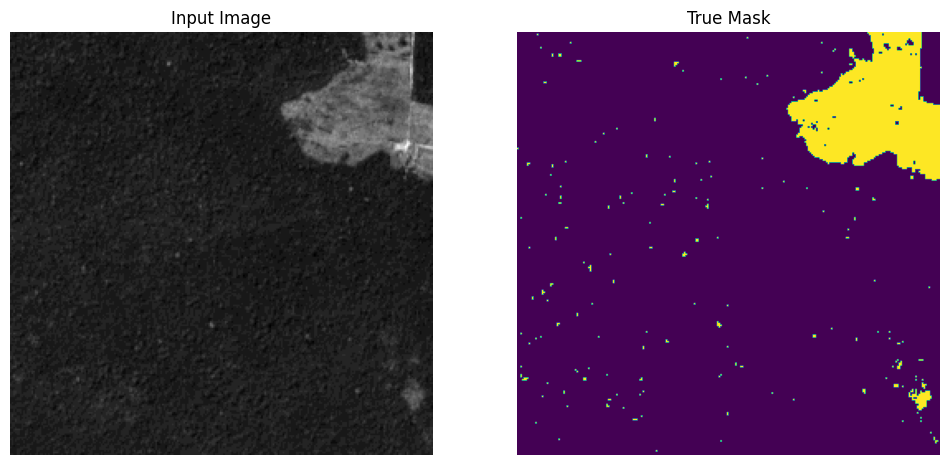

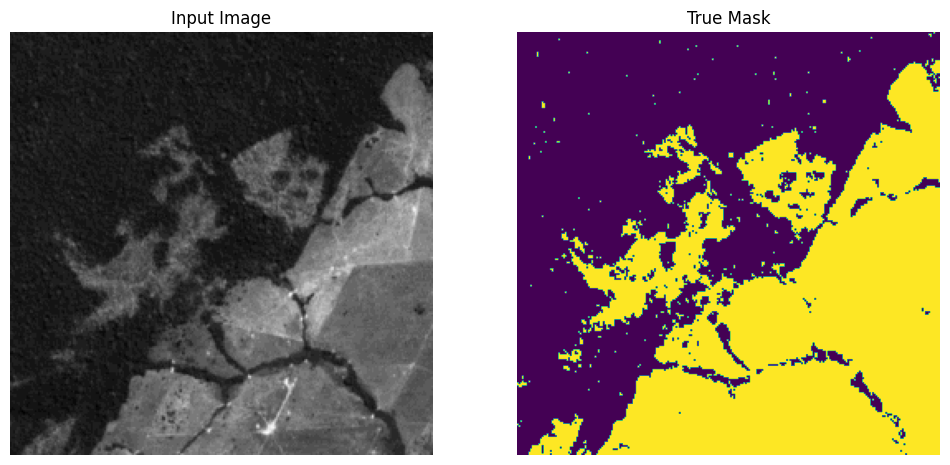

In [220]:
for i in range(5):
    for image, mask in train.take(i):
        sample_image, sample_mask = image, mask
        display([sample_image, sample_mask])

**Model**

We are going to use U-Net model. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder.The encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in tf.keras.applications.

In [221]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = True 

C:\Users\bahti\AppData\Local\Temp\ipykernel_13288\3181086618.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)


In [222]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class InstanceNormalization(Layer):
    def __init__(self, axis=-1, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.axis = axis
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:], initializer='ones')
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:], initializer='zeros')
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

        result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [223]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

**Train the model**

Now let's compile the model and see the model architecture

In [232]:
# def dice_coef(y_true, y_pred, smooth=1):
#     intersection = K.sum(y_true * y_pred, axis=[1,2,3])
#     union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
#     return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

# def dice_loss(in_gt, in_pred):
#     return 1-dice_coef(in_gt, in_pred)

# model = unet_model(1)

# model.compile(optimizer='adam',
#               loss = dice_loss,
#               metrics=[dice_coef,'binary_accuracy'])

# tf.keras.utils.plot_model(model, show_shapes=True)

# Define IoU (Intersection over Union) Metric
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1, 2, 3]) - intersection
    return K.mean((intersection + smooth) / (union + smooth), axis=0)

# Define IoU Loss Function (using 1 - IoU)
def iou_loss(y_true, y_pred):
    return 1 - iou(y_true, y_pred)

# Define Dice Coefficient
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

# Define Dice Loss (using 1 - Dice Coefficient)
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Define Binary Cross-Entropy Loss
def bce_loss(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

# Combine IoU Loss, Dice Loss, and Binary Cross-Entropy
def combined_loss(y_true, y_pred, alpha=0.5, beta=0.5, gamma=0.5):
    return alpha * iou_loss(y_true, y_pred) + beta * dice_loss(y_true, y_pred) + gamma * bce_loss(y_true, y_pred)

# Compile Model with Combined Loss Function and Metrics
model = unet_model(1)

model.compile(optimizer='adam',
              loss=combined_loss,
              metrics=[iou, dice_coef, 'binary_accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Lets do some prediction before training

In [225]:
model.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_40       │ [(None, 128, 128, │  1,841,984 │ input_layer_43[0… │
│ (Functional)        │ 96), (None, 64,   │            │                   │
│                     │ 64, 144), (None,  │            │                   │
│                     │ 32, 32, 192),     │            │                   │
│                     │ (None, 16, 16,    │            │                   │
│                     │ 576), (None, 8,   │            │                   │
│                     │ 8, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_40       │ (None, 16, 16,    │  1,476,608 │ functional_40[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_32      │ (None, 16, 16,    │          0 │ sequential_40[0]… │
│ (Concatenate)       │ 1088)             │            │ functional_40[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_41       │ (None, 32, 32,    │  2,507,776 │ concatenate_32[0… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_33      │ (None, 32, 32,    │          0 │ sequential_41[0]… │
│ (Concatenate)       │ 448)              │            │ functional_40[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_42       │ (None, 64, 64,    │    516,608 │ concatenate_33[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_34      │ (None, 64, 64,    │          0 │ sequential_42[0]… │
│ (Concatenate)       │ 272)              │            │ functional_40[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_43       │ (None, 128, 128,  │    156,928 │ concatenate_34[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_35      │ (None, 128, 128,  │          0 │ sequential_43[0]… │
│ (Concatenate)       │ 160)              │            │ functional_40[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_52 │ (None, 256, 256,  │      1,441 │ concatenate_35[0… │
│ (Conv2DTranspose)   │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,501,345 (24.80 MB)

 Trainable params: 6,468,513 (24.68 MB)

 Non-trainable params: 32,832 (128.25 KB)

In [226]:
def visualize(display_list):
    plt.figure(figsize=(12,12))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


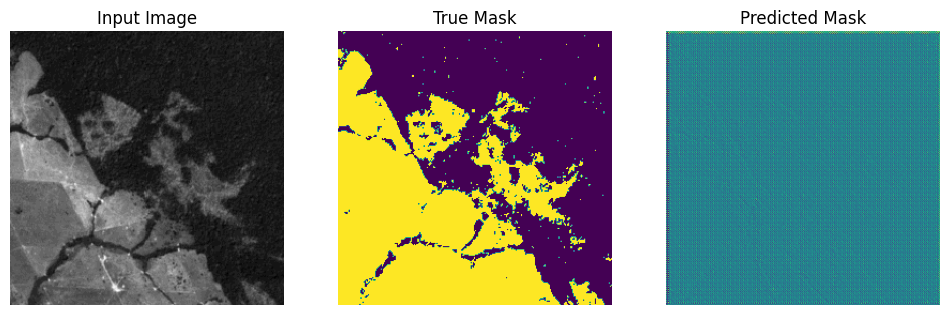

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


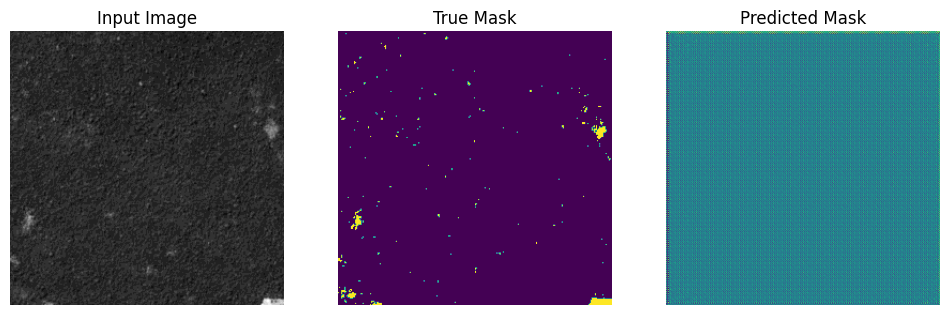

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


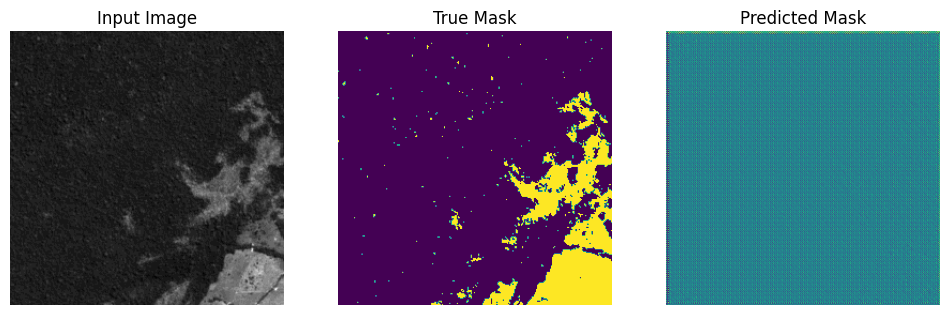

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


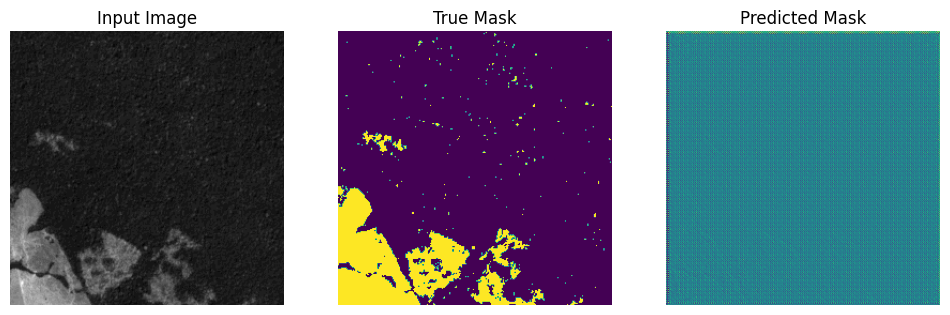

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


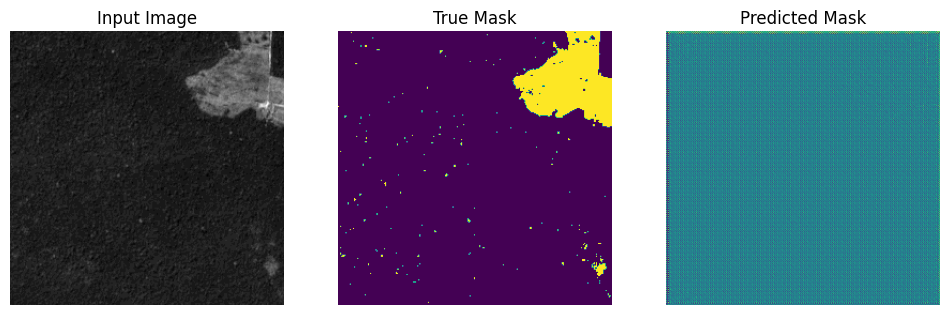

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


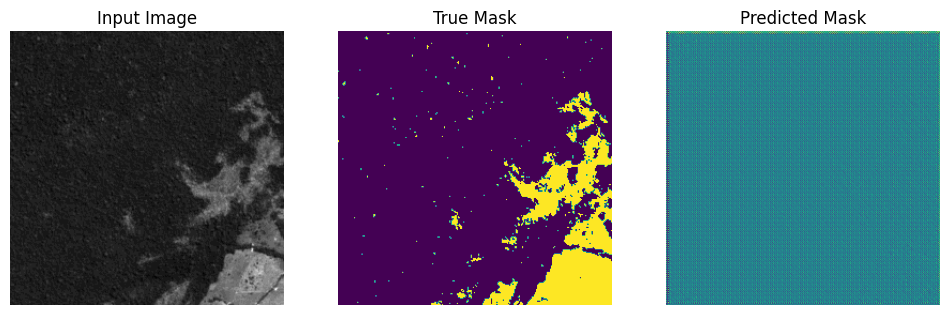

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


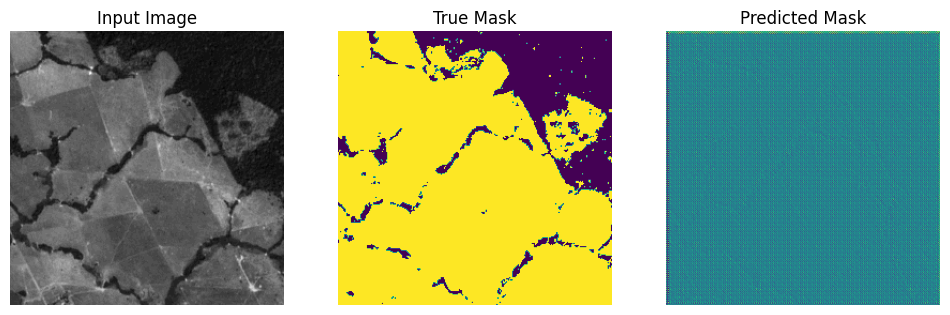

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


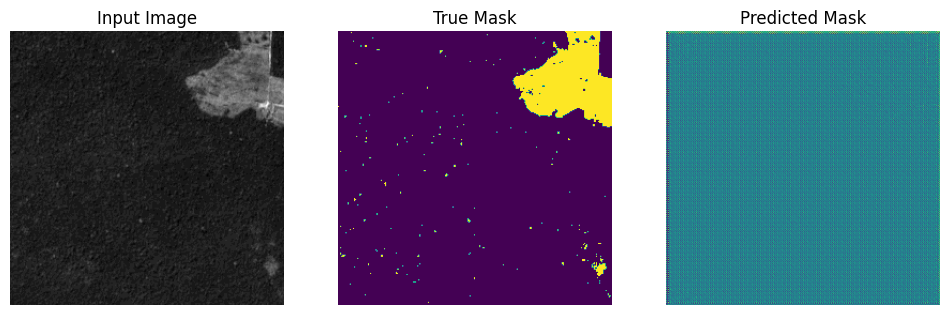

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


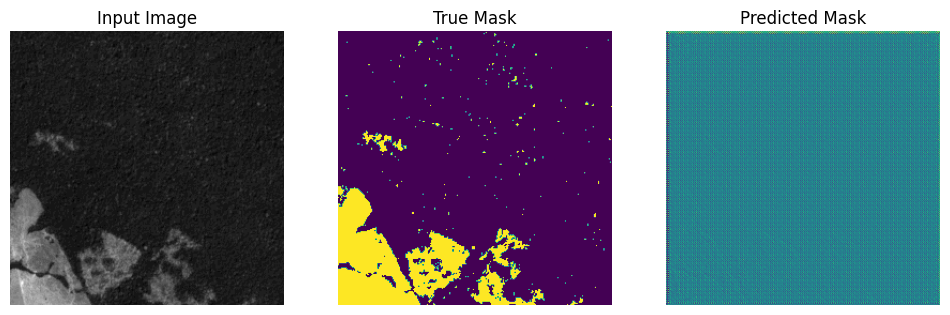

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


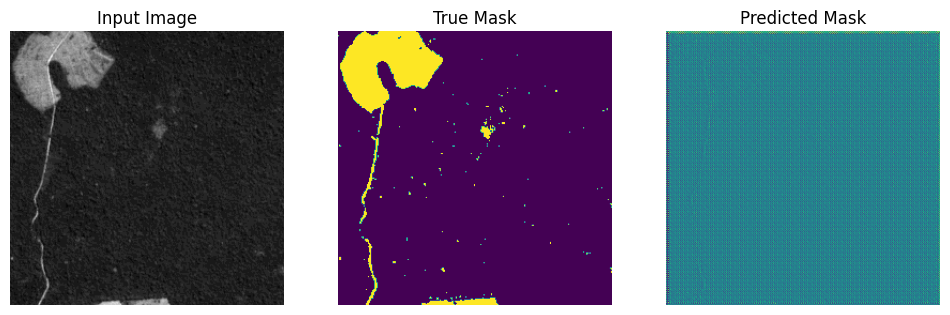

In [227]:
for i in range(5):
    for images, masks in train_dataset.take(i):
        for img, mask in zip(images, masks):
            sample_image = img
            sample_mask = mask
            show_predictions(sample_image, sample_mask)
            break

In [234]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)
EPOCHS = 40
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
# STEPS_PER_EPOCH = 1

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), early_stop])

**Testing**

We test the trained model on our test dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


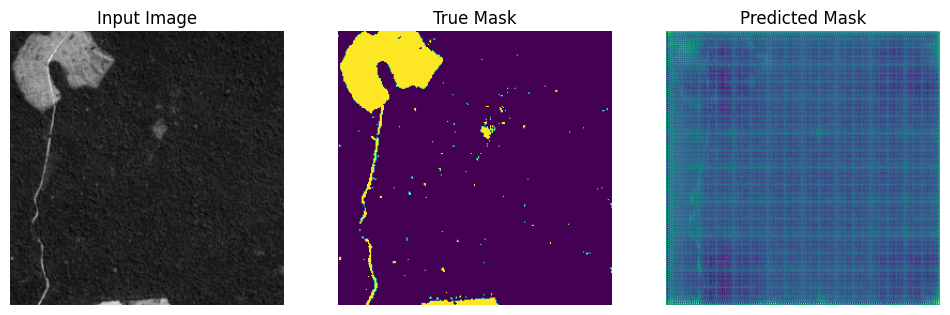

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


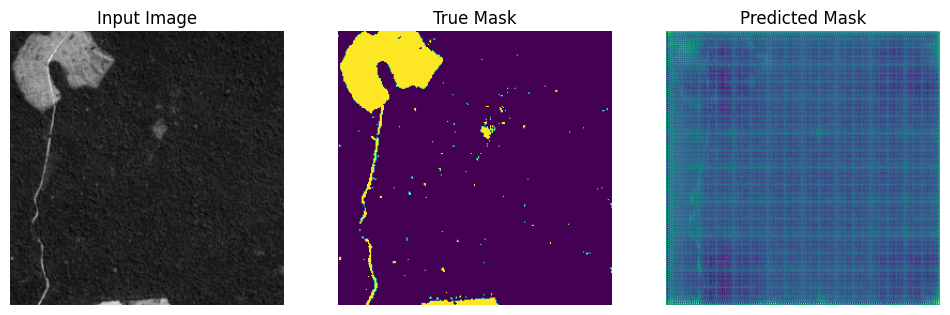

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


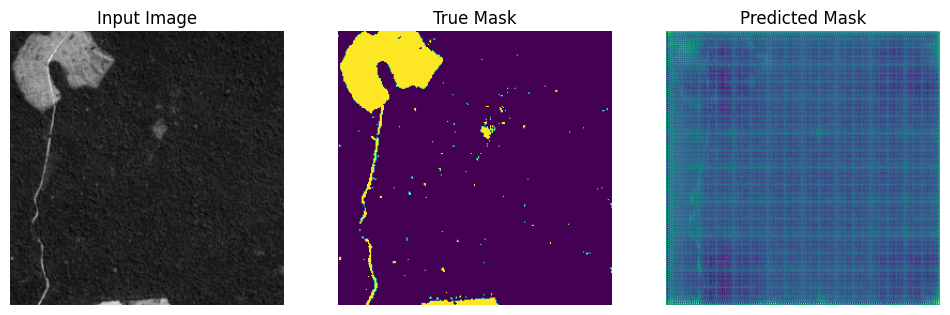

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


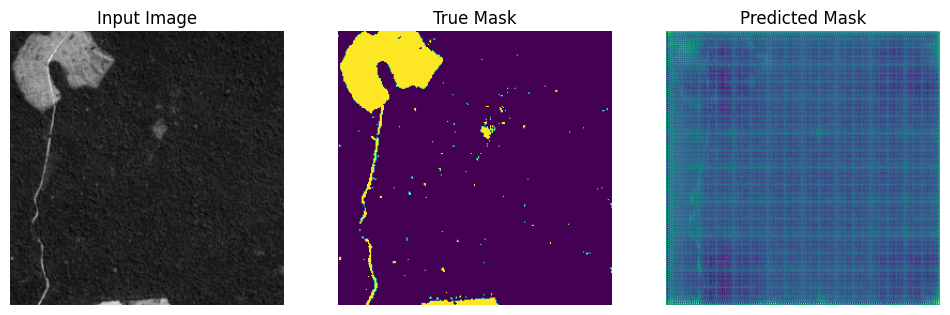

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


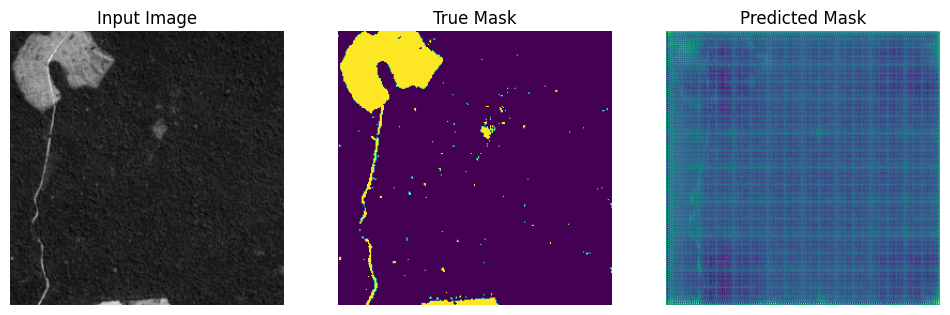

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


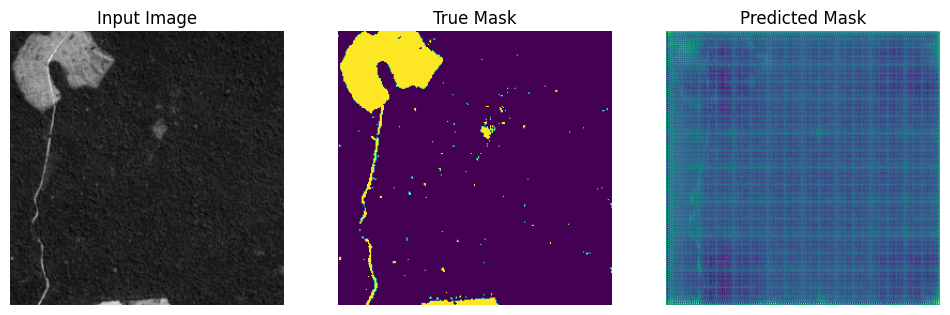

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


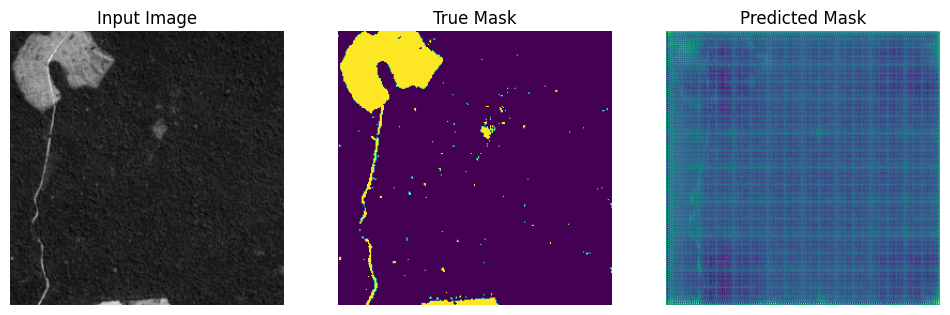

In [229]:
for i in range(8):
    for images, masks in test_dataset.take(i):
        for img, mask in zip(images, masks):
            tsample_image = img
            tsample_mask = mask
            show_predictions(tsample_image, tsample_mask)
            break

**Evaluation**



In [230]:
def plot_accuracy_loss(model_history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(model_history.history['binary_accuracy'],'bo--', label = "acc")
    plt.plot(model_history.history['val_binary_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(model_history.history['loss'],'bo--', label = "loss")
    plt.plot(model_history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

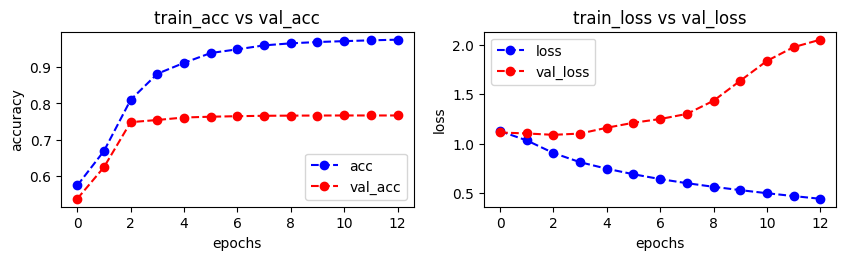

In [231]:
plot_accuracy_loss(model_history)

**Acknowledgements**

https://www.kaggle.com/code/dikshabhati2002/image-segmentation-u-net/notebook